In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlrd
import geopandas as gpd

In [25]:
RESOURCE_MAX = .25
INDICATORS = {
    'overall':{
        'crit':{
            'antimony':  {'vmax':RESOURCE_MAX},
            'beryllium': {'vmax':RESOURCE_MAX},
            'bismuth':   {'vmax':RESOURCE_MAX},
            'cadmium':   {'vmax':RESOURCE_MAX},
            'chromium':  {'vmax':RESOURCE_MAX},
            'cobalt':    {'vmax':RESOURCE_MAX},
            'graphite':  {'vmax':RESOURCE_MAX},
            'lithium':   {'vmax':RESOURCE_MAX},
            'magnesium': {'vmax':RESOURCE_MAX},
            'manganese': {'vmax':RESOURCE_MAX},
            'molybdenum':{'vmax':RESOURCE_MAX},
            'niobium':   {'vmax':RESOURCE_MAX},
            'palladium': {'vmax':RESOURCE_MAX},
            'platinum':  {'vmax':RESOURCE_MAX},
            'ree':       {'vmax':RESOURCE_MAX},
            'rhodium':   {'vmax':RESOURCE_MAX},
            'titanium':  {'vmax':RESOURCE_MAX},
            'tungsten':  {'vmax':RESOURCE_MAX},
            'uranium':   {'vmax':RESOURCE_MAX},
            'zirconium': {'vmax':RESOURCE_MAX},
        },
        'metals':{
            'aluminum':  {'vmax':RESOURCE_MAX},
            'copper':    {'vmax':RESOURCE_MAX},
            'gold':      {'vmax':RESOURCE_MAX},
            'silver':    {'vmax':RESOURCE_MAX},
            'nickel':    {'vmax':RESOURCE_MAX},
            'zinc':      {'vmax':RESOURCE_MAX},
            'lead':      {'vmax':RESOURCE_MAX},
            'steel':     {'vmax':RESOURCE_MAX},
            'tin':       {'vmax':RESOURCE_MAX},
        },
        'ag':{
            'coffee':    {'vmax':RESOURCE_MAX},
            'maize':     {'vmax':RESOURCE_MAX},
            'milk':      {'vmax':RESOURCE_MAX},
            'palm':      {'vmax':RESOURCE_MAX},
            'pork':      {'vmax':RESOURCE_MAX},
            'poultry':   {'vmax':RESOURCE_MAX},
            'rice':      {'vmax':RESOURCE_MAX},
            'soy':       {'vmax':RESOURCE_MAX},
            'sugar':     {'vmax':RESOURCE_MAX},
            'wheat':     {'vmax':RESOURCE_MAX},
            'beef':      {'vmax':RESOURCE_MAX},
        },
        'energy':{
            'gas':       {'vmax':RESOURCE_MAX},
            'oil':       {'vmax':RESOURCE_MAX},
            'coal':      {'vmax':RESOURCE_MAX},
        },
        'mil_ex': {'log':True, 'winsor':2.5},
        'arms': {
             'arms_ex': {'vmax':.5},
             'arms_im': {'vmax':.2},
        },
        'unga': {},
        'aid': {'vmax':.10},
        'trade':{'log':True, 'winsor':2.5},
        'fdi':{'log':True, 'winsor':2.5},
        'students':{
            'student_in':{'log':True, 'winsor':2.5},
            'student_out':{'log':True, 'winsor':2.5},
        }
    },
    'resources':{
        'crit',
        'metals',
        'ag',
        'energy',
    },
    'mil':{
        'arms',
        'mil_ex',
    },
    'diplo':{
        'unga',
        'aid',
    },
    'soft':{
        'trade',
        'fdi',
        'students'
    }
}
def iterind(f, indicators=None, **kwargs):
    if indicators is None:
        indicators = INDICATORS
    for k,v in indicators.items():
        if (type(v) is dict and len(v) and not ('vmin' in v or 'vmax' in v or 'log' in v)):
            iterind(f, v, **kwargs)
        f(k, v, **kwargs)

In [26]:
countries = pd.read_csv('countries.csv')
countries = countries.set_index('iso_a3').drop('-99')
#shps = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
shps = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip')
shps.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,Fiji,FJI,...,피지,Fiji,Fidżi,Fiji,Фиджи,Fiji,Fiji,Fiji,斐濟,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,United Republic of Tanzania,TZA,...,탄자니아,Tanzania,Tanzania,Tanzânia,Танзания,Tanzania,Tanzanya,Tanzania,坦桑尼亚,POLYGON ((33.90371119710453 -0.950000000000000...
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,Western Sahara,SAH,...,서사하라,Westelijke Sahara,Sahara Zachodnia,Saara Ocidental,Западная Сахара,Västsahara,Batı Sahra,Tây Sahara,西撒哈拉,POLYGON ((-8.665589565454809 27.65642588959236...
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,Canada,CAN,...,캐나다,Canada,Kanada,Canadá,Канада,Kanada,Kanada,Canada,加拿大,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,United States of America,USA,...,미국,Verenigde Staten van Amerika,Stany Zjednoczone,Estados Unidos,Соединённые Штаты Америки,USA,Amerika Birleşik Devletleri,Hoa Kỳ,美国,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


In [27]:
dat = pd.read_csv('all_ind2.csv')
dat.set_index('iso', inplace=True)
dat['fdi_us'].loc[dat['fdi_us']==0] = np.nan
dat['fdi_cn'].loc[dat['fdi_cn']==0] = np.nan
dat['country'] = countries['name']
dat = dat[countries['primary']>0]
dat.head()


/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,country,aluminum_us,aluminum_cn,antimony_us,antimony_cn,beryllium_us,beryllium_cn,bismuth_us,bismuth_cn,cadmium_us,...,aid_us,aid_cn,unga_us,unga_cn,arms_ex_us,arms_im_us,arms_ex_cn,arms_im_cn,mil_ex_us,mil_ex_cn
iso,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.064,0.001,0.23,0.82,0.47,0.0,0.00,0.0,0,0
ALB,Albania,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005,0.000,0.48,0.50,0.00,0.0,0.00,0.0,10,0
DZA,Algeria,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.17,0.81,0.01,0.0,0.18,0.0,4,0
AGO,Angola,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001,0.012,0.16,0.81,0.00,0.0,0.07,0.0,3,2
ARG,Argentina,0.019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.002,0.30,0.76,0.60,0.0,0.00,0.0,3,0


In [28]:
def norm(seq, vmin=None, vmax=None, log=False, winsor=False):
    if log:
        seq = seq+1
    if not vmin:
        if winsor:
            vmin = np.nanpercentile(seq, winsor)
        else:
            vmin = np.min(seq)
    if not vmax:
        if winsor:
            vmax = np.nanpercentile(seq, 100-winsor)
        else:
            vmax = np.max(seq)
    if log:
        seq = np.log(seq)
        vmin = np.log(vmin)
        vmax = np.log(vmax)
    s = (seq - vmin)/(vmax - vmin)
    s = np.clip(s, 0, 1)
    return s

In [55]:
out = pd.DataFrame(index=dat.index)
out['country'] = dat['country']

def agg(ind, args, df=out, max_resources=False):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if args == {} or 'vmin' in args or 'vmax' in args or 'log' in args:
        if usi in dat:
            if not 'vmax' in args:
                if 'winsor' in args:
                    args['vmax'] = np.nanpercentile(np.vstack((dat[usi], dat[cni])), 100-args['winsor'])
                else:
                    args['vmax'] = np.nanmax(np.vstack((dat[usi], dat[cni])))
            df[usi] = norm(dat[usi], **args)
            df.at['USA', usi] = np.nan
            if df[usi].min() == df[usi].max():
                df[usi] = np.nan
            df[cni] = norm(dat[cni], **args)
            df.at['CHN', cni] = np.nan
            if df[cni].min() == df[cni].max():
                df[cni] = np.nan
    else:
        usargs = ['{}_us'.format(arg) for arg in args]
        cnargs = ['{}_cn'.format(arg) for arg in args]
        df[usi] = np.nanmean(df[usargs], axis=1)
        df[cni] = np.nanmean(df[cnargs], axis=1)
        vmax = np.nanmax(np.vstack((df[usi], df[cni])))
        df[usi] = df[usi]/vmax
        df[cni] = df[cni]/vmax

out2 = out.copy()
iterind(agg, df=out)

out.head()

/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN axis encountered
/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN axis encountered


,country,antimony_us,antimony_cn,beryllium_us,beryllium_cn,bismuth_us,bismuth_cn,cadmium_us,cadmium_cn,chromium_us,...,overall_us,overall_cn,resources_us,resources_cn,mil_us,mil_cn,diplo_us,diplo_cn,soft_us,soft_cn
iso,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.356196,0.156156,0.000000,0.000000,0.313333,0.000000,0.656442,0.446165,0.414408,0.151128
ALB,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012,...,0.247928,0.112848,0.000788,0.010507,0.351383,0.000000,0.278929,0.220260,0.320180,0.200402
DZA,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.203521,0.263634,0.004823,0.003215,0.242510,0.120000,0.060803,0.433638,0.449693,0.366247
AGO,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.215398,0.362683,0.014468,0.125386,0.203145,0.207655,0.060256,0.501368,0.518090,0.433120
ARG,Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.436601,0.306706,0.084954,0.108872,0.536478,0.000000,0.140558,0.410510,0.670511,0.481641


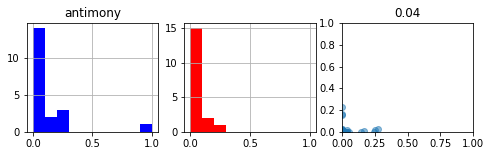

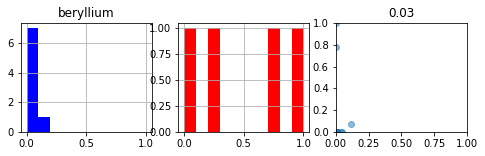

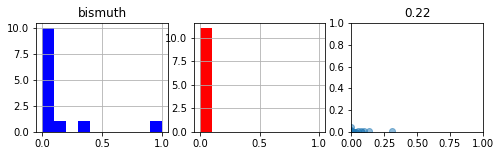

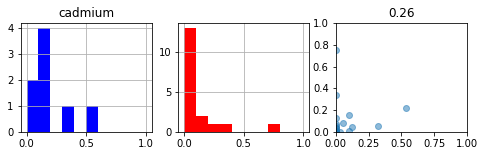

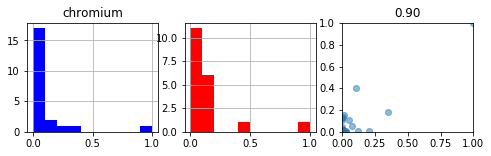

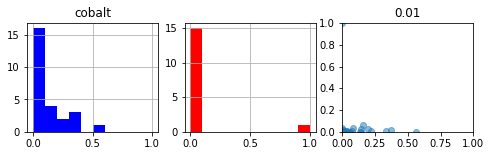

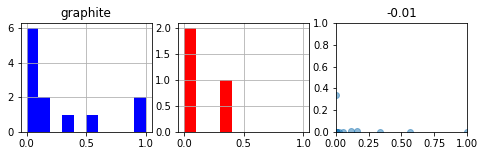

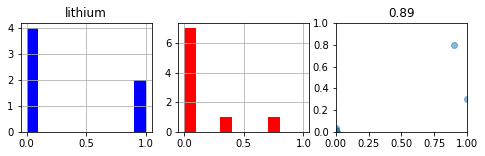

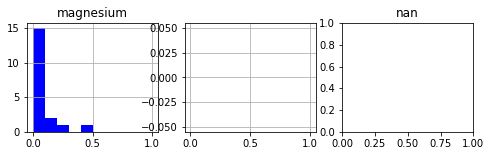

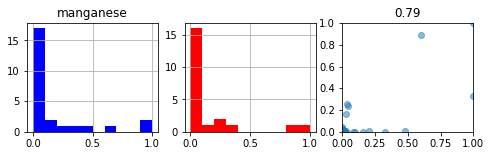

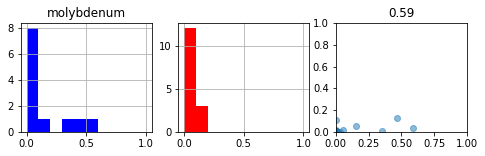

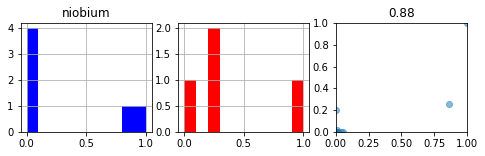

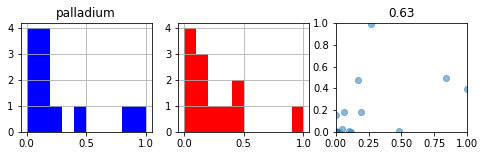

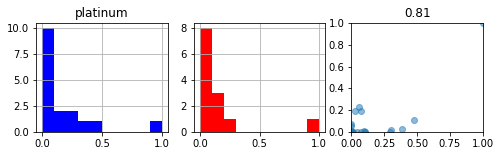

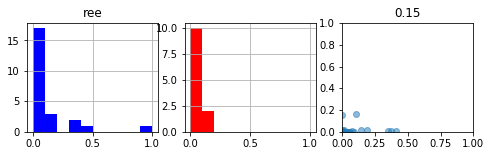

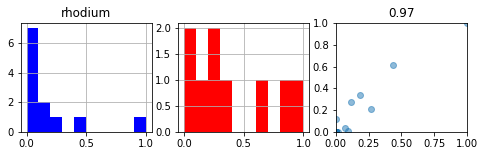

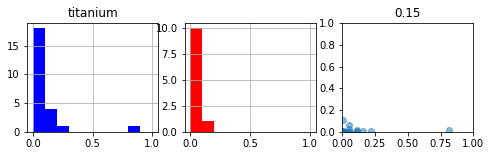

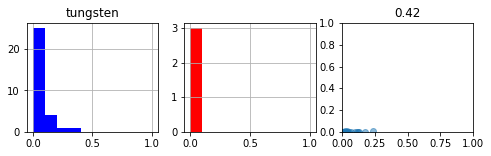

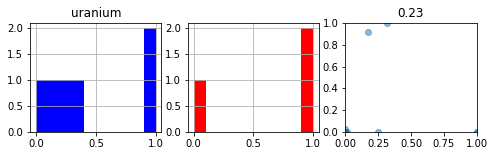

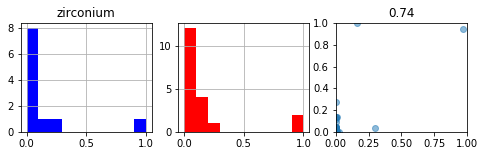

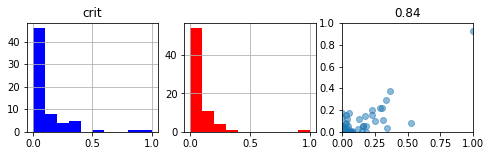

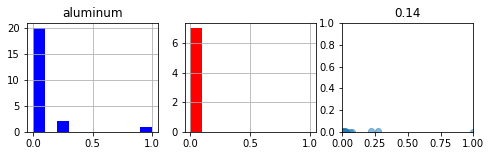

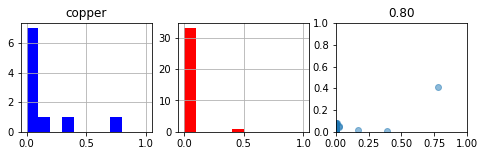

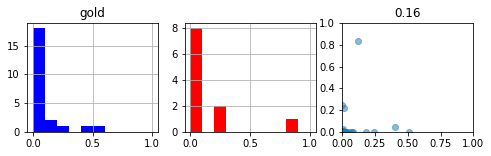

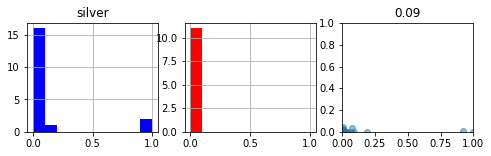

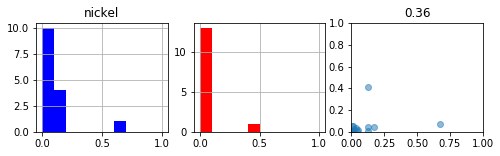

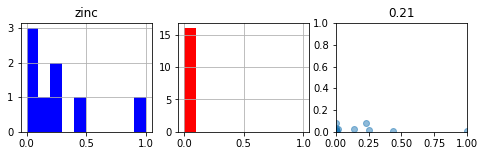

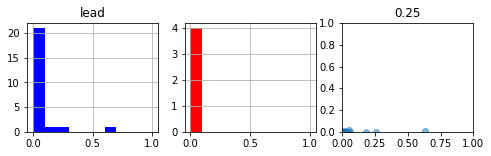

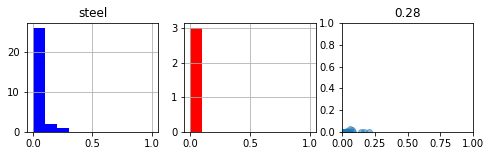

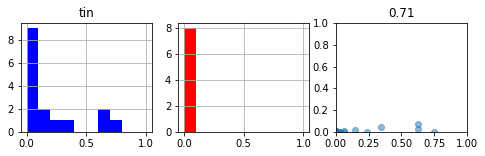

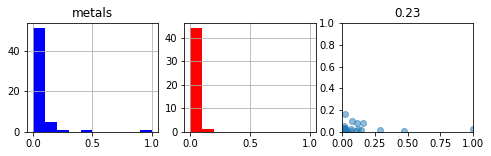

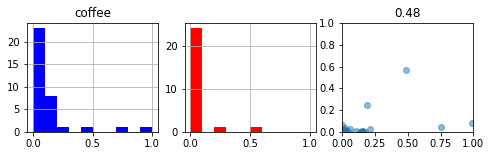

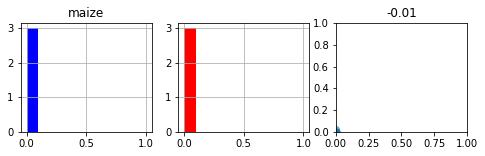

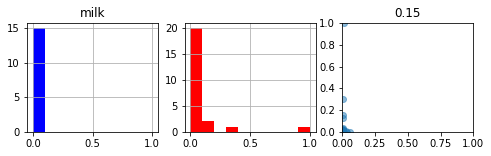

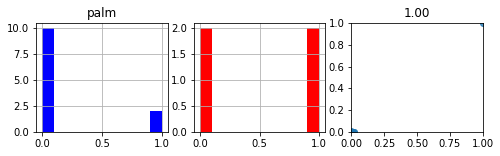

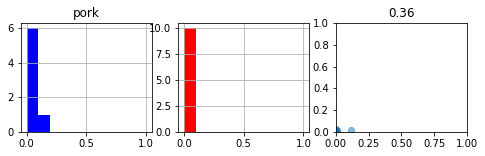

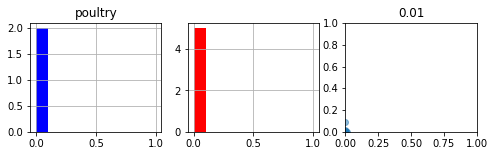

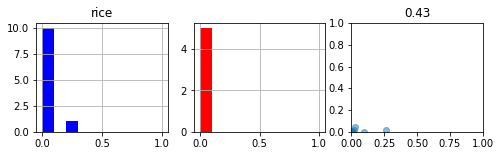

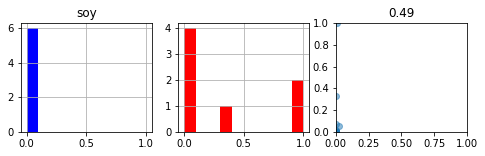

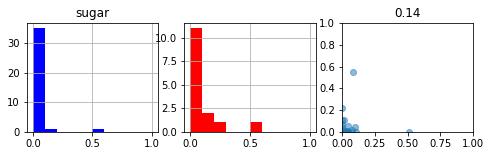

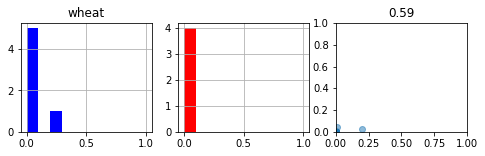

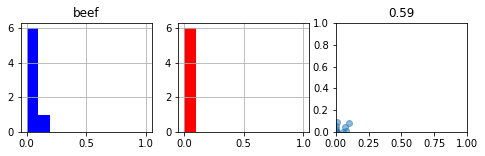

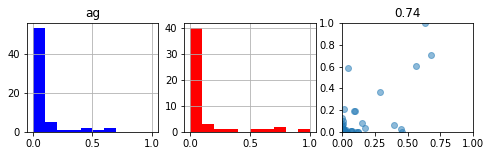

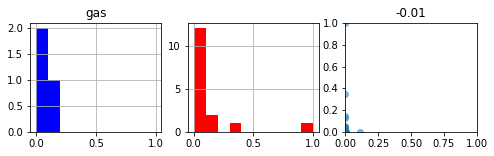

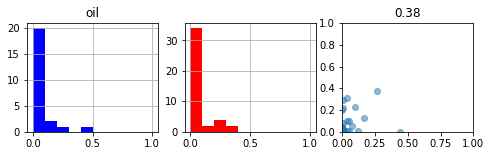

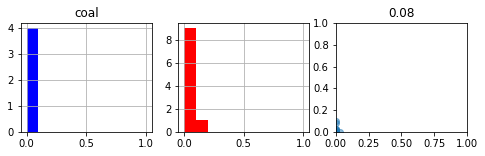

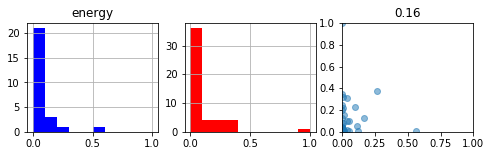

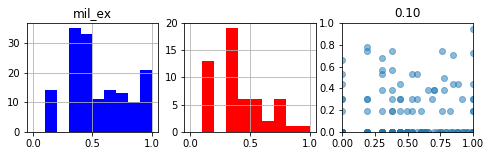

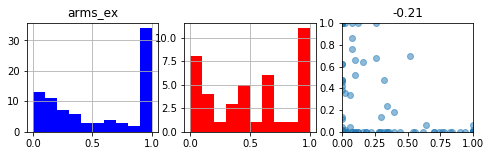

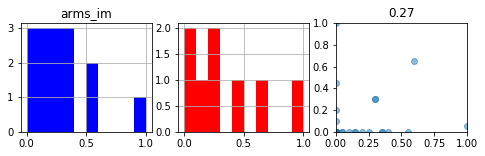

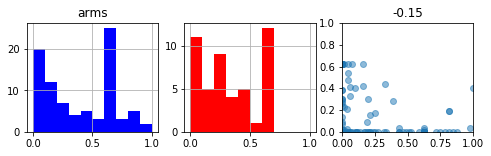

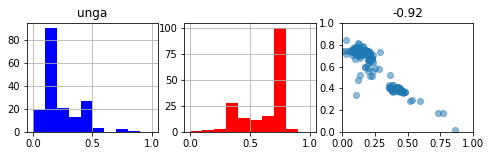

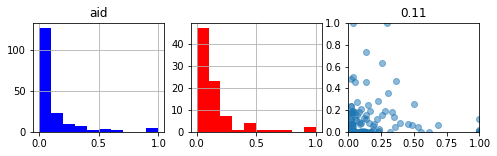

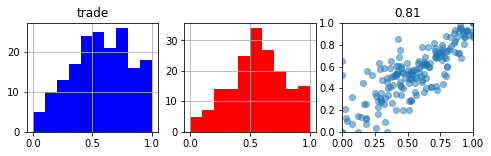

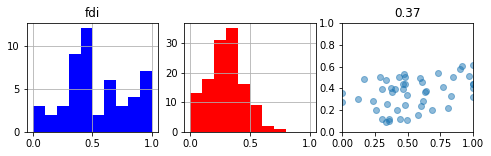

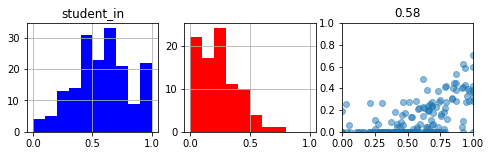

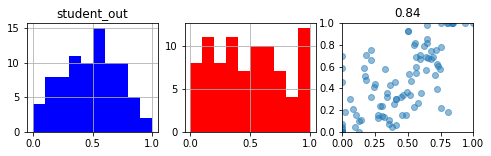

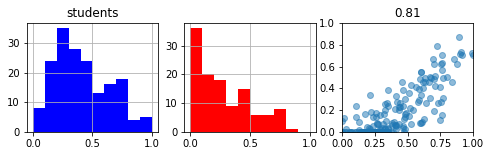

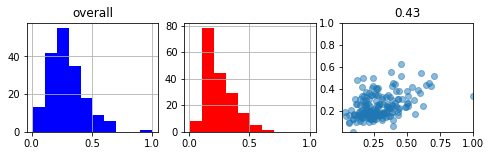

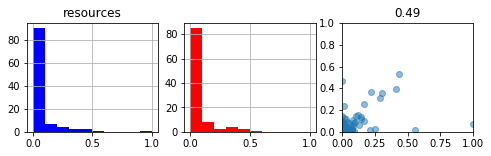

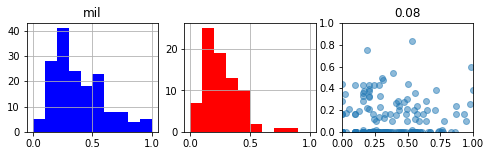

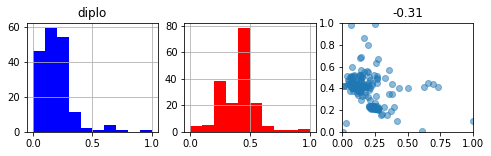

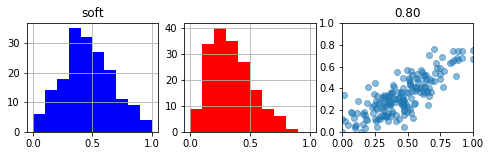

In [56]:
def plots(ind, *args, dat=dat, vmax=None, skipzeros=False):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        x = dat[usi].copy()
        y = dat[cni].copy()
        both = np.vstack((x,y))
        vmin = np.nanmin(both)
        if not vmax:
            vmax = np.nanmax(both)
        if skipzeros:
            x.loc[x==0] = np.nan
            y.loc[y==0] = np.nan
        fig, axs = plt.subplots(1, 3, figsize=(8, 2))
        x.hist(ax=axs[0], color='b', range=(vmin, vmax))
        y.hist(ax=axs[1], color='r', range=(vmin, vmax))
        axs[2].scatter(dat[usi], dat[cni], alpha=.5)
        axs[2].set_xlim((vmin, vmax))
        axs[2].set_ylim((vmin, vmax))
        axs[0].set_title(ind)
        axs[2].set_title("{:0.2f}".format(dat[[usi,cni]].corr().iloc[1,0]))
        fig.show()
iterind(plots, dat=out, vmax=1, skipzeros=True)

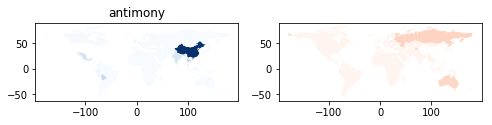

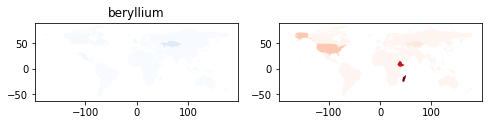

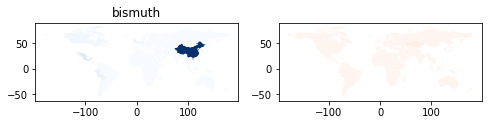

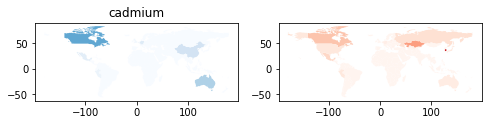

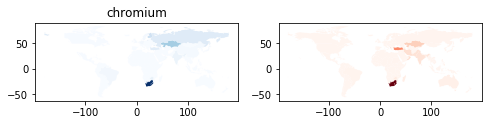

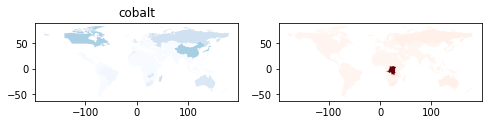

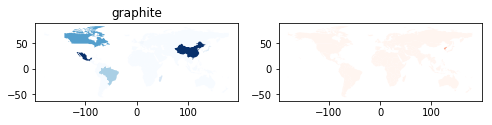

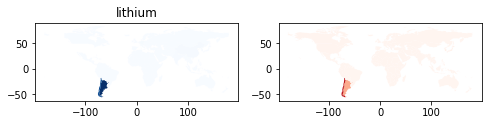

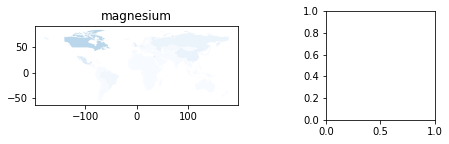

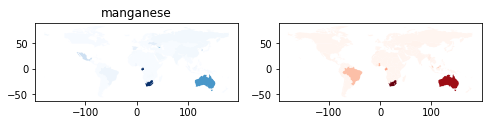

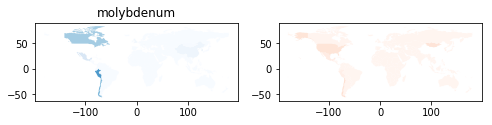

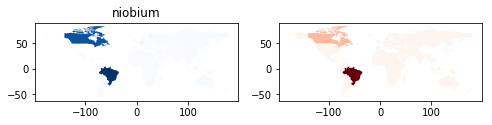

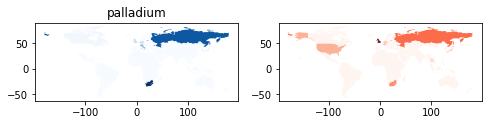

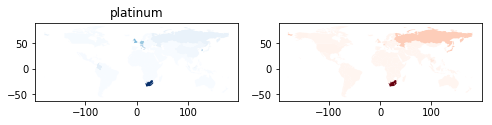

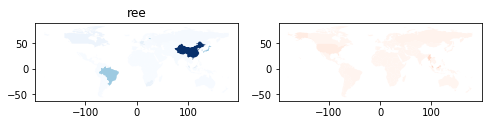

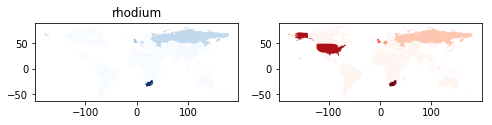

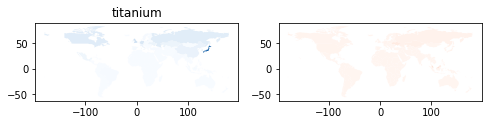

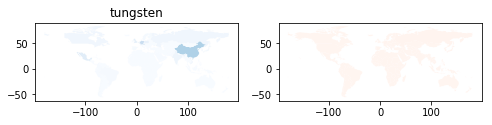

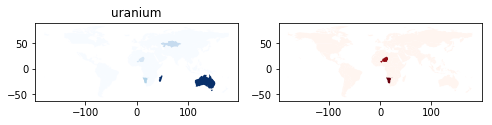

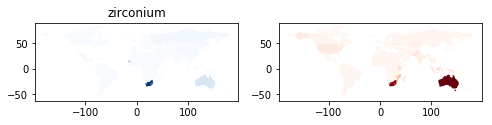

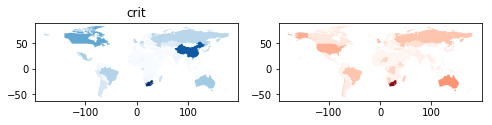

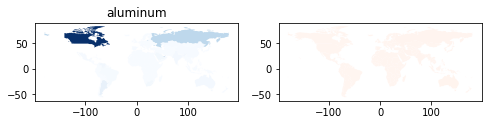

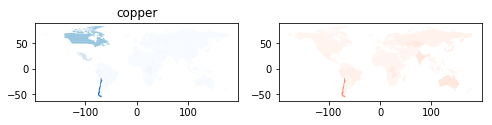

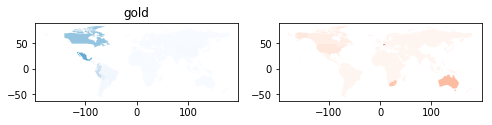

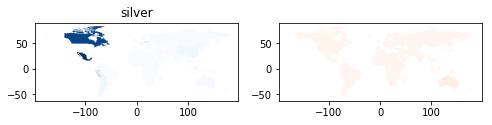

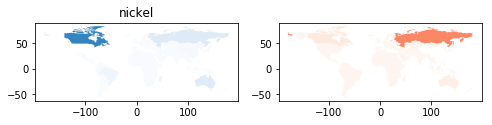

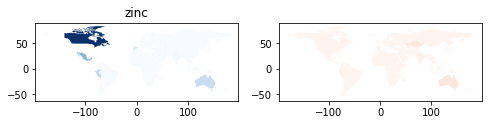

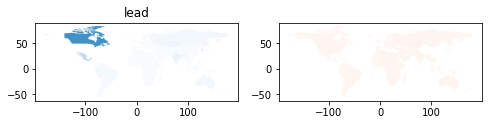

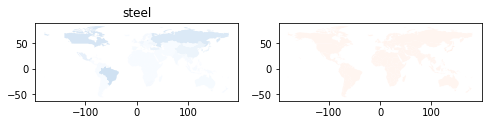

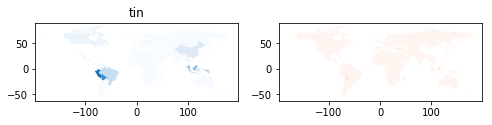

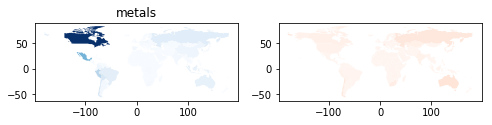

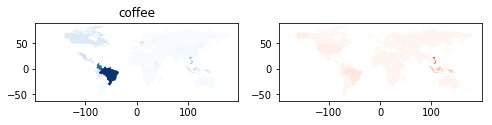

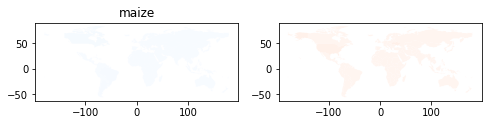

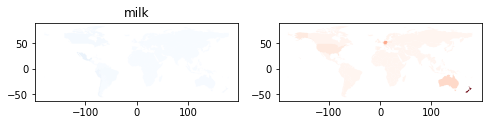

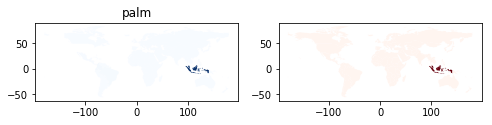

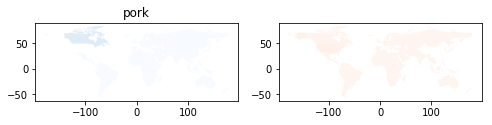

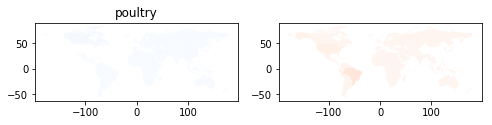

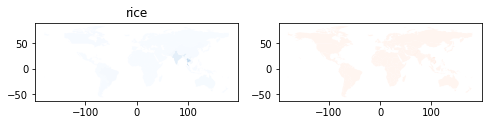

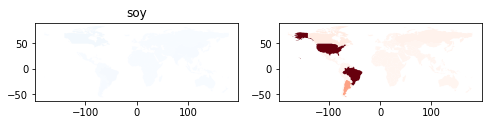

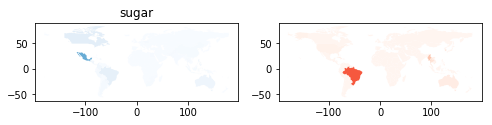

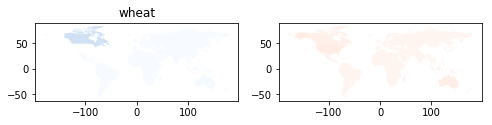

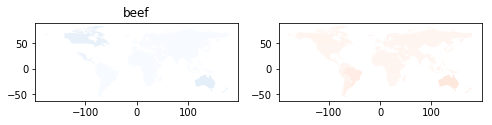

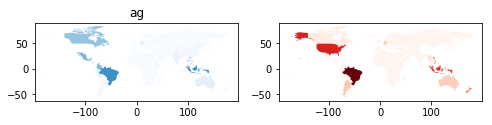

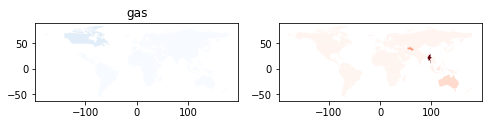

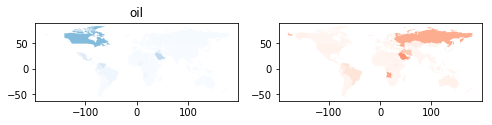

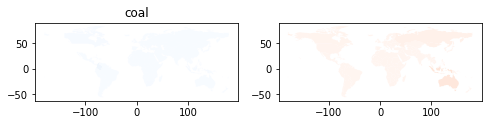

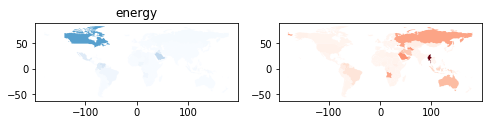

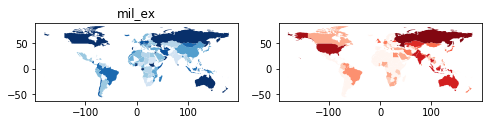

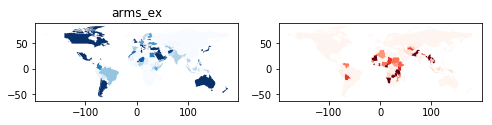

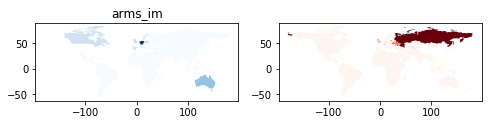

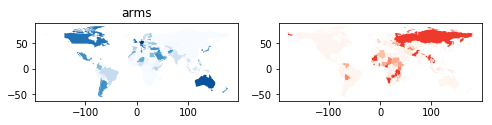

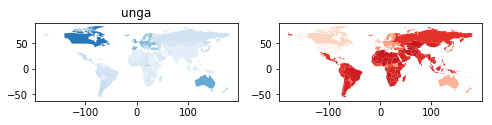

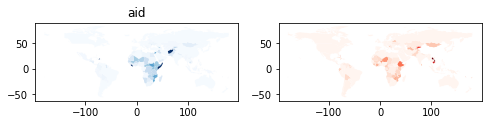

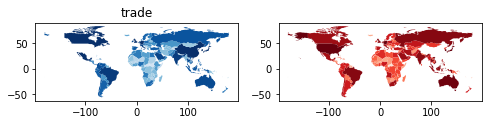

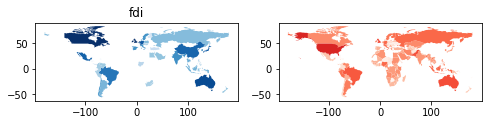

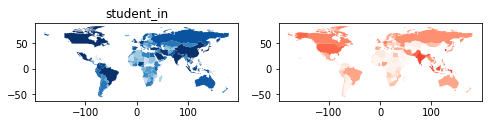

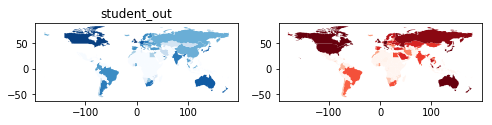

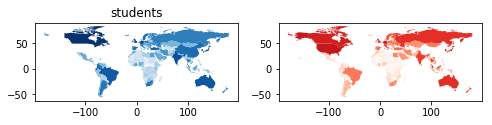

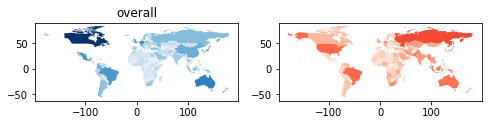

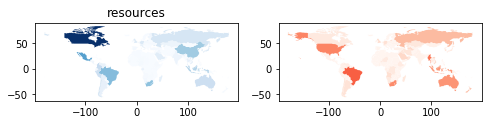

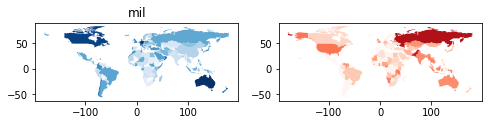

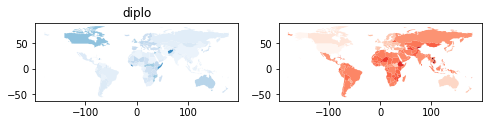

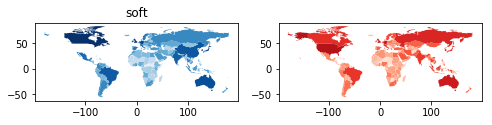

In [57]:
def maps(ind, *args, dat=dat, vmax=None):
    shp2 = shps.set_index('ISO_A3').join(dat)
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        fig, axs = plt.subplots(1, 2, figsize=(8, 2))
        shp2[shp2[usi].notna()].plot(usi, ax=axs[0], cmap='Blues', vmax=vmax)
        shp2[shp2[cni].notna()].plot(cni, ax=axs[1], cmap='Reds', vmax=vmax)
        axs[0].set_title(ind)
        fig.show()
iterind(maps, dat=out, vmax=1)

In [58]:
def tops(ind, *args, dat=dat, n=10):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        print(ind)
        print(dat.set_index('country')[usi].sort_values(ascending=False).head(n))
        print(dat.set_index('country')[cni].sort_values(ascending=False).head(n))
        print('\n')
iterind(tops, dat=out)

antimony
country
China             1.000
Thailand          0.272
Bolivia           0.252
Belgium           0.244
Mexico            0.168
India             0.148
France            0.056
Peru              0.040
United Kingdom    0.040
Japan             0.036
Name: antimony_us, dtype: float64
country
Tajikistan    0.224
Russia        0.168
Australia     0.156
Thailand      0.024
Kyrgyzstan    0.024
Myanmar       0.024
Kazakhstan    0.012
Laos          0.012
Peru          0.012
Bolivia       0.012
Name: antimony_cn, dtype: float64


beryllium
country
Kazakhstan        0.120
Czech Republic    0.048
United Kingdom    0.044
Mexico            0.020
Philippines       0.012
Canada            0.008
Austria           0.008
France            0.004
Fiji              0.000
Germany           0.000
Name: beryllium_us, dtype: float64
country
Madagascar                  1.000
Ethiopia                    0.780
United States of America    0.204
Kazakhstan                  0.072
Zimbabwe                    

country
South Korea                 0.704079
Malaysia                    0.620190
India                       0.598918
Indonesia                   0.583895
Pakistan                    0.527154
United States of America    0.505104
Portugal                    0.482919
Bangladesh                  0.452632
Singapore                   0.446164
Germany                     0.434567
Name: student_in_cn, dtype: float64


student_out
country
United Kingdom        1.000000
Canada                0.939876
France                0.846376
Germany               0.839993
Australia             0.834945
New Zealand           0.809041
Grenada               0.806777
Japan                 0.795640
Dominican Republic    0.756144
South Korea           0.755508
Name: student_out_us, dtype: float64
country
Australia                   1.000000
Germany                     1.000000
Japan                       1.000000
South Korea                 1.000000
Canada                      1.000000
United States of America

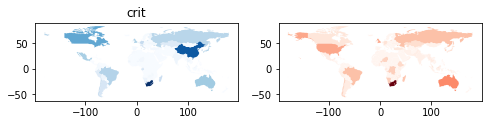

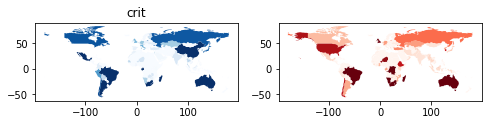

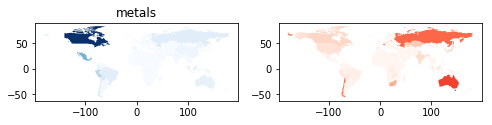

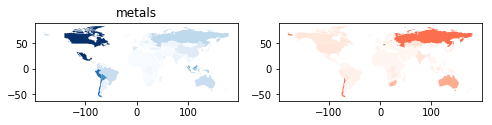

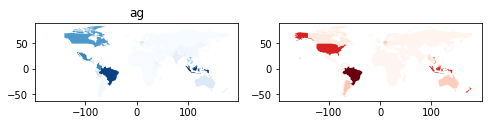

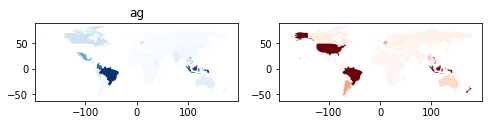

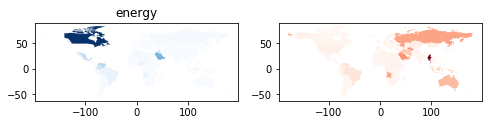

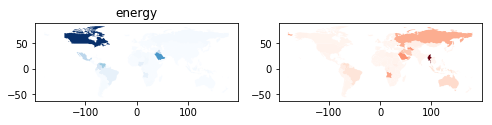

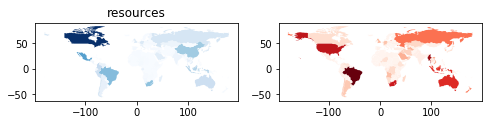

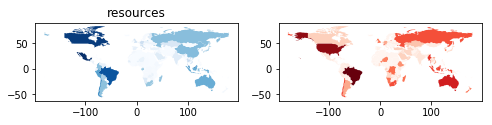

In [63]:
maps('crit', dat=out)
maps('crit', dat=out2)
maps('metals', dat=out)
maps('metals', dat=out2)
maps('ag', dat=out)
maps('ag', dat=out2)
maps('energy', dat=out)
maps('energy', dat=out2)
maps('resources', dat=out)
maps('resources', dat=out2)

In [60]:
out.to_csv('scored_values.csv')

resources
country
Canada          1.000000
Mexico          0.559871
Brazil          0.433665
South Africa    0.410206
China           0.363996
Indonesia       0.302694
Malaysia        0.289369
Colombia        0.248252
Australia       0.217939
Peru            0.210188
Name: resources_us, dtype: float64
country
Brazil                      0.530007
Myanmar                     0.470593
United States of America    0.419274
South Africa                0.395928
Australia                   0.364118
Indonesia                   0.357598
Malaysia                    0.307538
Russia                      0.253486
New Zealand                 0.235866
Vietnam                     0.158625
Name: resources_cn, dtype: float64




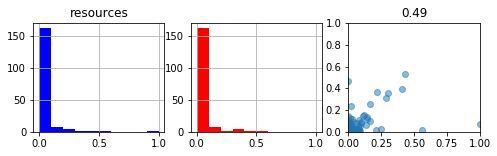

In [64]:
tops('resources', dat=out)
plots('resources', dat=out)
